# Notebook 6: Tree Ensembles

In diesem Notebook schauen wir uns die Verwendung von Ensemble Tree Modellen an und eine Möglichkeit die Cross-Validation einfacher zu gestalten.

Hinweis: Der ML-Worflow in diesem Notebook stark vereinfacht (d.h. kein Auffüllen von N/As und kein Feature-Scaling).

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
print("Sklearn version:", sklearn.__version__)

pd.options.mode.chained_assignment = None  # avoid slide-copy-warning 

Pandas version: 2.0.3
Numpy version: 1.24.3
Sklearn version: 1.3.0


In [2]:
df = pd.read_csv("data/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df_selection = df[["Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]]
df_selection = df_selection.dropna()
df_selection.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [4]:
df_X = df_selection.drop(columns = ["Survived"])
df_y = df_selection["Survived"]
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=0)

### Einfacher Entscheidungsbaum

Zuerst trainieren wir einen einfachen Entscheidungsbaum auf den Titanic-Daten:

In [5]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion="entropy")
model.fit(X_train, y_train);

In [6]:
from sklearn.metrics import accuracy_score
predictions = model.predict(X_test)
accuracy_score(y_test, predictions)

0.6223776223776224

Im Folgenden schauen wir uns an, wie das mit RandomForest und GBT funktioniert.

### Random Forest (RF)

In [7]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train);

In [8]:
predictions = model.predict(X_test)
accuracy_score(y_test, predictions)

0.6713286713286714

### Gradient Boosting Tree (GBT)

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, y_train);

In [10]:
predictions = model.predict(X_test)
accuracy_score(y_test, predictions)

0.7342657342657343

### Cross-Validation Revisited

In der letzten praktischen Übung haben wir schon mehrere Möglichkeiten gesehen, um eine Cross-Validation durchzuführen. Diese Methoden waren aber entweder recht aufwändig (im Sinne von viel Code) oder haben nur für einzelne Modelle funtioniert (z.B. `LassoCV`).

Im Folgenden schauen wir uns eine einfach Methode an, mit der man eine schnelle Cross-Validation für beliebige Modelle durchführen kann.

In [11]:
from sklearn.model_selection import GridSearchCV

parameter_candidates = [{'max_depth': [3, 4, 5]}]
gbt = GradientBoostingClassifier(random_state=0)
grid_clf = GridSearchCV(estimator=gbt, param_grid=parameter_candidates, n_jobs=-1)
grid_clf.fit(X_train, y_train);

In [12]:
print('Best max_depth:', grid_clf.best_estimator_.max_depth)
print('Best score:', grid_clf.best_score_)

Best max_depth: 3
Best score: 0.6953165522501907


D.h. der beste Hyperparameter für die maximale Baumtiefe ist `max_depth=3` mit einem Score von ~0.69 in der Cross-Validation.

### Bonus: Out-of-bag evaluation Random Forest
Abschließend schauen wir uns noch kurz an, wie Hyperparameter mit Hilfe der "Out-of-bag"-Methode gefunden werden können. Dies hat den Vorteil, dass man keine extra Validierungsdaten benötigt.
Hinweis: Der folgende Code folgt im Wesentlichen [dieser Quelle](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html).

In [13]:
model = RandomForestClassifier(random_state=0, oob_score=True)

min_estimators = 100
max_estimators = 175
max_features = ["sqrt", 1, 0.7]

results = {}
for max_feature in max_features:
    scores = []
    for i in range(min_estimators, max_estimators + 1):
        model.set_params(n_estimators=i, max_features=max_feature)
        model.fit(X_train, y_train)
        scores.append((i, model.oob_score_))
    results[max_feature] = scores

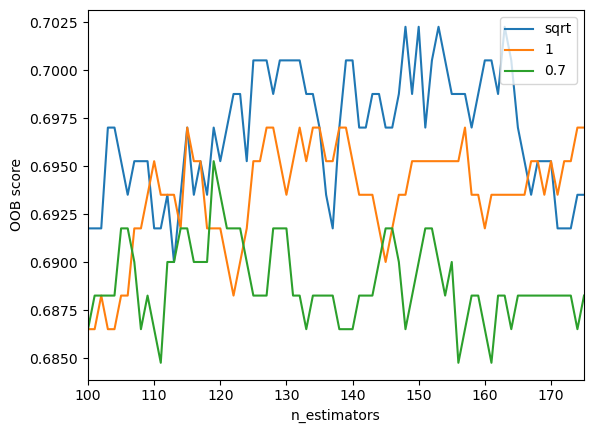

In [14]:
import matplotlib.pyplot as plt

for label, clf_scores in results.items():
    xs, ys = zip(*clf_scores)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB score")
plt.legend(loc="upper right")
plt.show()

In [15]:
import numpy
# get best config
max_label = ""
max_trees = 0
max_score = 0
for label, clf_scores in results.items():
    xs, ys = zip(*clf_scores)
    if np.max(ys) > max_score:
        max_score = np.max(ys)
        max_trees = np.argmax(ys) + min_estimators
        max_label = label

print(f"Best config: {max_label, max_trees, max_score}")

Best config: ('sqrt', 148, 0.702276707530648)
